# Project 4: Andvanced Road Lane Lines

by Uki D. Lucas

This project is suppoeded to meet following requirements:
https://review.udacity.com/#!/rubrics/571/view

## Overview

In this project, I will identify the road lane boundaries in a video.

## Objectives

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called **camera_cal**.  

The images in **test_images** are for testing your pipeline on single frames.  

If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows.    

The video called **project_video.mp4** is the video your pipeline should work well on.  

The **challenge_video.mp4** video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  

**The harder_challenge.mp4 video is another optional challenge and is brutal!**

If you're feeling ambitious (again, totally optional though), don't stop there!  

We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

## Image References

Undistorted
<img src="examples/undistort_output.png" alt="Undistorted" />

Road Transformed
<img src="test_images/test1.jpg" alt="Road Transformed" />

Binary Example
<img src="examples/binary_combo_example.jpg" alt="Binary Example" />
 
Warp Example
<img src="examples/warped_straight_lines.jpg" alt="Warp Example" />
 
Fit Visual
<img src="examples/color_fit_lines.jpg" alt="Fit Visual" />
 
Output
<img src="examples/example_output.jpg" alt="Output" />

Video 

<video width="320" height="240" controls>
  <source src="project_video.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

# Rubric Points

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

## Writeup / README

1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  Here is a template writeup for this project you can use as a guide and a starting point.

You're reading it!

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

#### OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

The very well documented code for this step is contained in document **camera_calibration**  available in HTML, ipynb and py formats. 

The result of calibration is following, red lines were applied manually:

<img src="example_calibration.png" />



found 20 calibration image samples
example camera_cal/calibration1.jpg
Removing distortion in test_images/test1.jpg
NOT OPTIMIZED: edges are cropped.


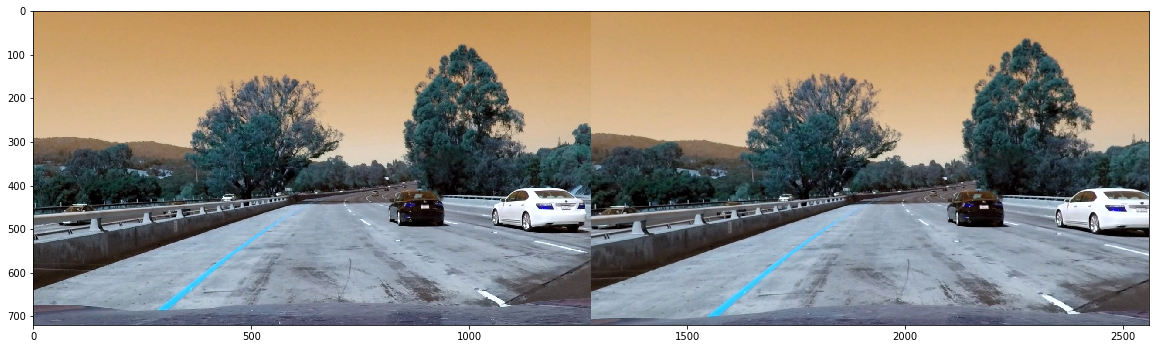

Removing distortion in test_images/test1.jpg
OPTIMIZED: fuller image, but with edge distortion.


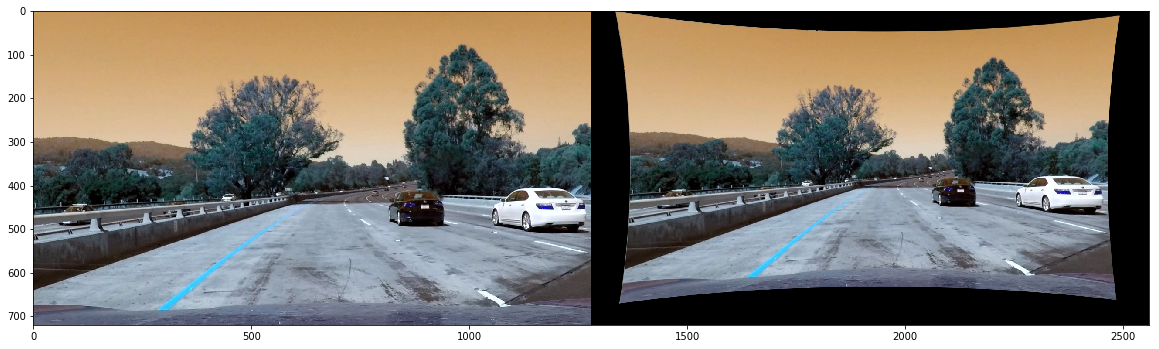

NameError: name 'correct_camera_distortion' is not defined

In [1]:
import glob
image_file_names = glob.glob("camera_cal/calibration*.jpg")

import camera_calibration as cam # locally in same directory
matrix, matrix_optimized, distortion = cam.define_calibration_parameters(
    image_file_names, 
    use_optimized = True)

In [ ]:
image_file_name = "test_images/test1.jpg"
image_corrected = apply_correction(image_file_name, matrix, distortion)
image_corrected = apply_correction(image_file_name, matrix, distortion, matrix_optimized)

## Pipeline (single images)

### 1. Distortion-corrected image

#### Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:


### 2. Color transforms, gradients or other methods to create a thresholded binary image.

#### A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in another_file.py).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

### 3. Perspective transform

#### OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.

The code for my perspective transform includes a function called warper(), which appears in lines 1 through 8 in the file example.py (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The warper() function takes as inputs an image (img), as well as source (src) and destination (dst) points.  I chose the hardcode the source and destination points in the following manner:

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

This resulted in the following source and destination points:

   Source  	Destination
  585, 460 	  320, 0   
  203, 720 	 320, 720  
  1127, 720	 960, 720  
  695, 460 	  960, 0   

I verified that my perspective transform was working as expected by drawing the src and dst points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

### 4. Identified lane-line pixels and fit their positions with a polynomial

#### Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

### 5. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

#### Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

I did this in lines # through # in my code in my_other_file.py

### 6. Image of the result plotted back down onto the road such that the lane area is identified clearly.

#### The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

I implemented this step in lines # through # in my code in yet_another_file.py in the function map_lane().  Here is an example of my result on a test image:

# Pipeline (video)

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

#### The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

Here's a link to my video result

# Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

#### Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

In [ ]:
# see http://nbconvert.readthedocs.io/en/latest/usage.html
!jupyter nbconvert --to markdown README.ipynb

In [ ]:
# see http://nbconvert.readthedocs.io/en/latest/usage.html
!jupyter nbconvert --to html README.ipynb